# Social Network Analysis. Predict salary and new connections 

Network Analysis. Supervised Learning. Regression (Salary prediction) and Classification (New connections prediction)

Goal: Predict missing salaries and new email connections from a company's email network 

Data from [Applied Social Network Analysis in Python | Coursera](https://www.coursera.org/learn/python-social-network-analysis/):

`net_emails.txt`: network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people. 
The network also contains the node attributes Department (*name*) and ManagementSalary (1 = Receiving a management salary)

`net_future_connections.csv`: future conections of pair of nodes currently unconnected (1 = an edge between those two nodes will exist in the future)



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import networkx as nx
import pickle

import helper

# A. Salary Prediction

## 1. Data Processing

#### Load graph 

In [2]:
graph = nx.read_gpickle('data/net_emails.txt')

print(nx.info(graph))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


#### Extract node attributes and features to a dataframe

In [3]:
graph.nodes(data=True)[:3]

[(0, {'Department': 1, 'ManagementSalary': 0.0}),
 (1, {'Department': 1, 'ManagementSalary': nan}),
 (2, {'Department': 21, 'ManagementSalary': nan})]

In [4]:
# Dataframe with node attributes
df_one = pd.DataFrame(index=graph.nodes())   # df_one: complete df
attributes = [k for k in graph.nodes(data=True)[0][1]]
for a in attributes:
    df_one[a] = pd.Series(nx.get_node_attributes(graph, a))

# node features
df_one['clustering'] = pd.Series(nx.clustering(graph))
df_one['degree'] = pd.Series(graph.degree())

df_one.head()

,Department,ManagementSalary,clustering,degree
0,1,0.0,0.276423,44
1,1,NaN,0.265306,52
2,21,NaN,0.297803,95
3,21,1.0,0.384910,71
4,21,1.0,0.318691,96


#### Explore the target and separate the prediction set

In [5]:
target = ['ManagementSalary']
features = [col for col in df_one if col not in target]

print(df_one[target].squeeze().value_counts(dropna=False))

 0.0    634
NaN     252
 1.0    119
Name: ManagementSalary, dtype: int64


In [6]:
df = df_one[(df_one['ManagementSalary'] == 0) | (df_one['ManagementSalary'] == 1)]
df_pred = df_one[df_one['ManagementSalary'].isnull()]

assert df.shape[0], df_pred.shape[0] == df_original.shape[0]

`df_one`: complete set <br>
`df`: set to train, validate, and test  <br>
`df_pred`: prediction set (no labels)

#### Split data into training and test set

In [7]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df, test_size=0.2, stratify=df[target], random_state=0)

del df

#### Classify features
Change categorical variables as dtype 'categorical' and sort columns: numerical + categorical + target

In [8]:
import helper

cat = ['Department', 'ManagementSalary']
num = ['clustering', 'degree']

df_train = helper.classify_data(df_train, target, categorical=cat)

pd.DataFrame(dict(df_train.dtypes), index=["Type"])[df_train.columns].head()

numerical features:   2
categorical features: 1
target 'ManagementSalary': category


,clustering,degree,Department,ManagementSalary
Type,float32,float32,category,category


In [9]:
#df_train, dict_categories = helper.remove_categories(df_train, target, ratio=0.01, show=True, dict_categories=None)

### Show training data

#### Numerical Features

In [10]:
df_train[num].describe(percentiles=[0.5])

,clustering,degree
count,602.000000,602.000000
mean,0.399478,33.318935
std,0.256666,38.390644
min,0.000000,1.000000
50%,0.377350,22.000000
max,1.000000,347.000000


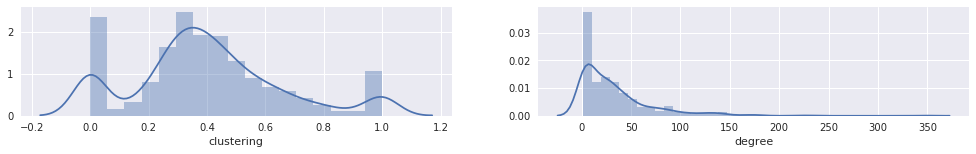

In [11]:
helper.show_numerical(df_train[num], kde=True)

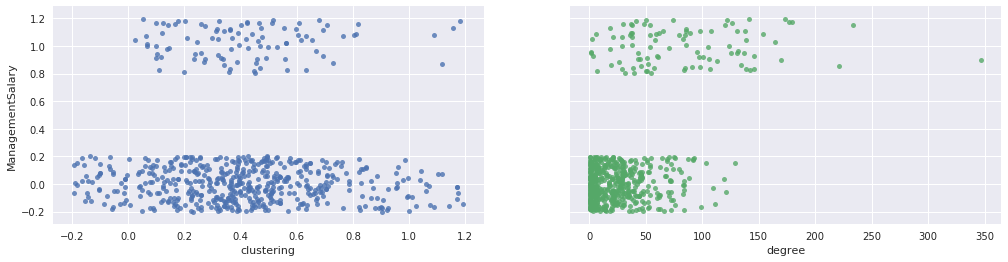

In [12]:
helper.show_target_vs_numerical(df_train, target, jitter=0.2, fit_reg=False, point_size=100)

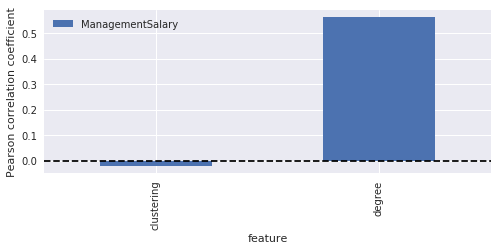

In [13]:
helper.show_correlation(df_train, target)

#### Categorical Features

In [14]:
df_train[cat].describe()

,Department,ManagementSalary
count,602,602.0
unique,41,2.0
top,4,0.0
freq,70,507.0


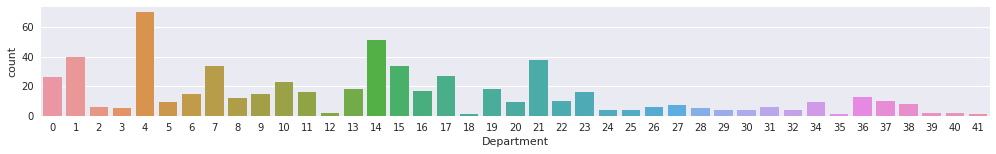

In [15]:
helper.show_categorical(df_train[cat], target, sharey=True)

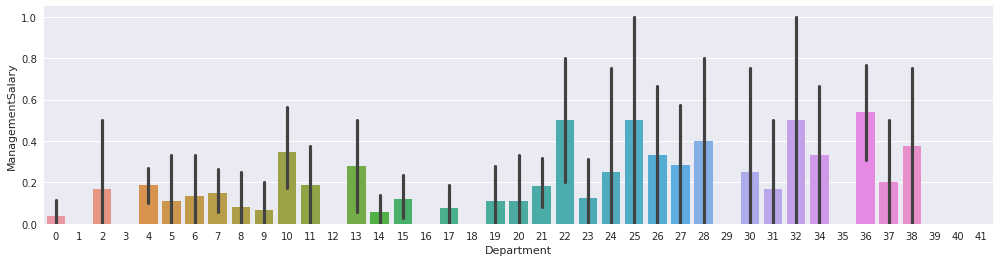

In [16]:
helper.show_target_vs_categorical(df_train, target)

#### Missing values

In [17]:
high_missing = helper.missing(df_train, limit=0.4)
#helper.fill_simple(df_train, target, missing_categorical=999, inplace=True)

No missing values found


In [18]:
copy_df = df_train.copy()  # checkpoint
del(df_train)

## 2. Neural Network

In [19]:
df_train = copy_df.copy() # Restore checkpoint
data = df_train.copy() 
# from now on use data instead of df

### Prepare data for Neural Network

#### Scale numerical variables

In [20]:
data, scale_param = helper.scale(data)

#### Create dummy features

In [21]:
# features only; target encoded later
data, dict_dummies = helper.replace_by_dummies(data, target)

# save features order for tests and predictions
model_features = [f for f in data if f not in target] 

data.head(3)

,clustering,degree,ManagementSalary,Department_0,Department_1,Department_2,Department_3,Department_4,Department_5,Department_6,...,Department_31,Department_32,Department_34,Department_35,Department_36,Department_37,Department_38,Department_39,Department_40,Department_41
620,2.339707,-0.763700,0.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10,-0.327388,0.356365,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
688,-1.556415,-0.841844,0.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Split the data into training and validation sets

In [22]:
def validation_split(data, val_size=0.15):
      
    train, val = train_test_split(
        data, test_size=val_size, random_state=0, shuffle=True, stratify=data[target])

    # Separate the data into features and target (x=features, y=target)
    x_train, y_train = train.drop(target, axis=1).values, train[target].values
    x_val, y_val = val.drop(target, axis=1).values, val[target].values

    return x_train, y_train, x_val, y_val


x_train, y_train, x_val, y_val = validation_split(data, val_size=0.2)

#### One-hot encode the output

In [23]:
import keras

def one_hot_output(y_train, y_val):
    num_classes = len(np.unique(y_train))
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    return y_train, y_val


y_train, y_val = one_hot_output(y_train, y_val)

Using TensorFlow backend.


In [24]:
print("train size \t X:{} \t Y:{}".format(x_train.shape, y_train.shape))
print("val size \t X:{} \t Y:{}".format(x_val.shape, y_val.shape))

train size 	 X:(481, 43) 	 Y:(481, 2)
val size 	 X:(121, 43) 	 Y:(121, 2)


### Build the Neural Network

In [25]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras import regularizers             

def build_nn_binary_classification(input_size, output_size, summary=False):

    input_nodes = input_size // 8

    model = Sequential()
    model.add(
        Dense(
            input_nodes,
            input_dim=input_size,
            kernel_regularizer=regularizers.l2(0.001)
        ))
    
    
    model.add(
        Dense(
            output_size,
            activation='softmax',
            kernel_regularizer=regularizers.l2(0.001)))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    if summary:
        model.summary()

    return model


build_nn = build_nn_binary_classification

### Train the Neural Network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 220       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 12        
Total params: 232
Trainable params: 232
Non-trainable params: 0
_________________________________________________________________
Training ....
time: 	 2.0 s


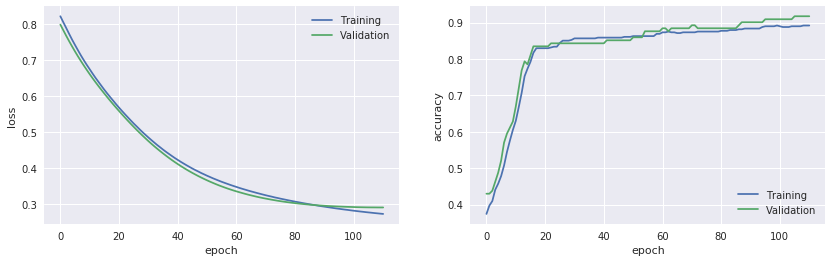


Training loss:  	0.2725
Validation loss: 	0.2905

Training accuracy: 	0.892
Validation accuracy:	0.917


In [26]:
import os
from time import time


def train_nn(model, x_train, y_train, validation_data=None, path=False, show=True):
    """ 
    Train the neural network model. If no validation_datais provided, a split for validation
    will be used
    """
    
    if show:
        print('Training ....')
    
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0)]
    t0 = time()

    history = model.fit(
        x_train,
        y_train,
        epochs=200,
        batch_size=128,
        verbose=0,
        validation_data = validation_data,
        #class_weight=cw,
        callbacks=callbacks)

    if show:
        print("time: \t {:.1f} s".format(time() - t0))
        helper.show_training(history)

    if path:
        model.save(path)
        print("\nModel saved at", path)
    
    return history
        

model = None
model = build_nn_binary_classification(x_train.shape[1], y_train.shape[1], summary=True)
train_nn(model, x_train, y_train, validation_data=(x_val, y_val));

### Evaluate the Model

In [27]:
data_test = helper.classify_data(df_test, target, categorical=cat)
data_test, _ = helper.scale(data, scale_param)
data_test, _ = helper.replace_by_dummies(data, target, dict_dummies)
data_test = data[model_features+target] # sort columns to match training features order
x_test, y_test = data_test.drop(target, axis=1).values, data_test[target].values
y_test = keras.utils.to_categorical(y_test, 2)

numerical features:   2
categorical features: 1
target 'ManagementSalary': category


In [28]:
from sklearn.metrics import roc_auc_score

score = model.evaluate(x_test, y_test, verbose=0)
print("\nNeural Network Accuracy: {:.3f}\n".format(score[1]))

y_pred = model.predict(x_test)

print('Neural Network ROC AUC:  {:.3f} \n'.format(roc_auc_score(y_test, y_pred)))


Neural Network Accuracy: 0.897

Neural Network ROC AUC:  0.914 



## 3. Compare with non-neural network models

In [29]:
y_train = y_train[:,1]
y_test = y_test[:,1]

In [30]:
# from sklearn.utils import class_weight
# y_plain = np.ravel(y_train)
# cw = class_weight.compute_class_weight('balanced', np.unique(y_plain), y_plain)
# cw = {idx : value for idx, value in enumerate(cw)}

In [31]:
# build and train the classifier
from sklearn.ensemble import RandomForestClassifier

clf=None
clf = RandomForestClassifier(n_estimators=50)
clf.fit(x_train, np.ravel(y_train))

print("\nRandom Forest Accuracy: {:.3f}\n".format(clf.score(x_train, y_train)))

y_pred = clf.predict_proba(x_test)

print('Random Forest ROC_AUC: {:.3f}'.format(roc_auc_score(y_test, y_pred[:,1])))


Random Forest Accuracy: 0.998

Random Forest ROC_AUC: 0.978


In [32]:
print("Best model:", clf)

Best model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [33]:
helper.ml_classification(x_train, y_train, x_test, y_test, cross_validation=False)


 Naive Bayes 
 --------------------
Test Accuracy:  	 0.296
ROC_AUC: 		 0.573
Training Time:  	 1.3 ms

 Decision Trees 
 --------------------
Test Accuracy:  	 0.970
ROC_AUC: 		 0.966
Training Time:  	 1.8 ms

 KNeighbors 
 --------------------
Test Accuracy:  	 0.899
ROC_AUC: 		 0.908
Training Time:  	 1.5 ms

 AdaBoost 
 --------------------
Test Accuracy:  	 0.929
ROC_AUC: 		 0.961
Training Time:  	 54.3 ms

 Random Forest 
 --------------------
Test Accuracy:  	 0.975
ROC_AUC: 		 0.986
Training Time:  	 109.9 ms


# B. Future Connection Prediction

In [35]:
del df_train, df_test, df_one, df_pred

In [36]:
df = pd.read_csv('data/net_future_connections.csv', index_col=0, converters={0: eval})
df.head(6)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0


#### Explore the target 

In [37]:
df['Future Connection'].value_counts(dropna=False)

 0.0    337002
NaN     122112
 1.0     29332
Name: Future Connection, dtype: int64

#### Extract edge-based attributes from the above graph

In [ ]:
df['Common Neighbors'] = df.index.map(lambda city: len(list(nx.common_neighbors(graph, city[0], city[1]))))
df['Jaccard Coefficient'] = [i[2] for i in nx.jaccard_coefficient(graph, df.index)]
df['ResourceWarningurce Allocation'] = [i[2] for i in nx.resource_allocation_index(graph, df.index)]
df['Adamic-Adar Index'] = [i[2] for i in nx.adamic_adar_index(graph, df.index)]
df['Preferential Attachment'] = [i[2] for i in nx.preferential_attachment(graph, df.index)]
df.head()